## 🧠 OptionFlow | Notebook_1_Baseline.ipynb
 --------------------------------------------------------
 Goal: Implement a finite-difference (FD) solver for the
       Black–Scholes PDE as the numerical "ground truth"
 --------------------------------------------------------
 PDE:
 ∂V/∂t + 0.5σ²S²∂²V/∂S² + rS∂V/∂S − rV = 0

 This notebook:
   1. Builds a discretized grid for S and t
   2. Solves the PDE backward in time (Crank-Nicolson scheme)
   3. Plots the resulting price surface

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import solve_banded
from scipy.stats import norm


In [142]:
# Parameters
S_max = 400      # Maximum stock price
K = 100          # Strike price
T = 1.0          # Time to maturity (years)
r = 0.05         # Risk-free rate
sigma = 0.2      # Volatility

# Grid resolution
M, N = 400, 1000  # Stock and time steps
dS = S_max / M
dt = T / N

# Spatial and temporal grids
S = np.linspace(0, S_max, M + 1)
t = np.linspace(0, T, N + 1)

# Option value matrix V(S, t)
V = np.zeros((M + 1, N + 1))

# Terminal condition: payoff at maturity (European call)
V[:, -1] = np.maximum(S - K, 0)


In [143]:
# Crank–Nicolson scheme (uniform S-grid)
# Interior indices correspond to S_i = i * dS for i = 1, ..., M-1

i_vals = np.arange(1, M)

a = 0.25 * dt * (sigma**2 * i_vals**2 - r * i_vals)
b = -0.5 * dt * (sigma**2 * i_vals**2 + r)
c = 0.25 * dt * (sigma**2 * i_vals**2 + r * i_vals)

# Assemble tridiagonal bands for implicit matrix A
A_diag = 1 - b
A_lower = -a[1:]
A_upper = -c[:-1]

ab_A = np.zeros((3, M - 1))
ab_A[0, 1:] = A_upper
ab_A[1, :] = A_diag
ab_A[2, :-1] = A_lower

# Boundary conditions across all time levels
theta = T - t
V[0, :] = 0.0
V[-1, :] = S_max - K * np.exp(-r * theta)

for j in reversed(range(N)):
    rhs = (
        a * V[0:M - 1, j + 1]
        + (1 + b) * V[1:M, j + 1]
        + c * V[2:, j + 1]
    )

    rhs[0] += a[0] * V[0, j]
    rhs[-1] += c[-1] * V[-1, j]

    V[1:M, j] = solve_banded((1, 1), ab_A, rhs)


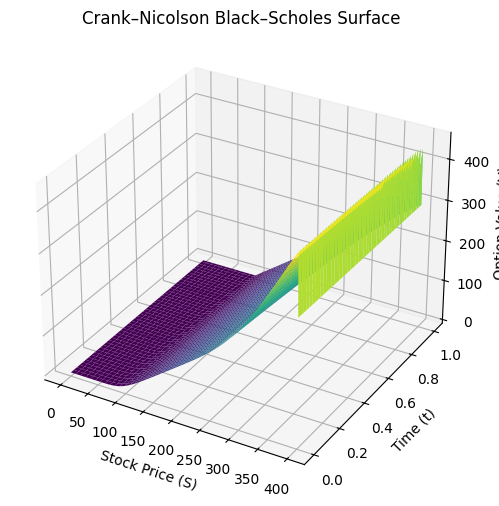

In [91]:
S_grid, T_grid = np.meshgrid(S, t)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, V.T, cmap='viridis')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Option Value (V)')
ax.set_title('Crank–Nicolson Black–Scholes Surface')
plt.show()


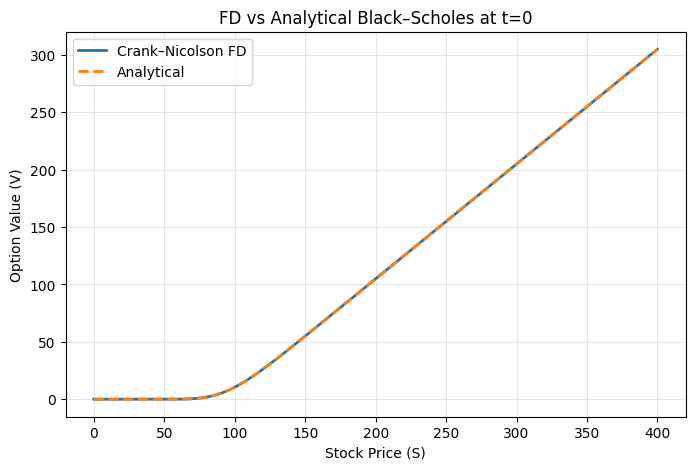

In [144]:
def black_scholes_call(S, K, T, r, sigma):
    """Analytical Black–Scholes solution for a European call option."""
    S_safe = np.maximum(S, 1e-12)
    if np.isscalar(T):
        if T <= 0:
            return np.maximum(S_safe - K, 0)
        T_safe = max(T, 1e-12)
    else:
        T_arr = np.asarray(T)
        T_safe = np.maximum(T_arr, 1e-12)

    sqrt_T = np.sqrt(T_safe)
    d1 = (np.log(S_safe / K) + (r + 0.5 * sigma**2) * T_safe) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    price = S_safe * norm.cdf(d1) - K * np.exp(-r * T_safe) * norm.cdf(d2)

    payoff = np.maximum(S_safe - K, 0)
    if np.isscalar(T):
        return price if T > 0 else payoff
    else:
        return np.where(T_arr > 0, price, payoff)

# Analytical price for each S at t=0
V_analytic = black_scholes_call(S, K, T, r, sigma)

plt.figure(figsize=(8,5))
plt.plot(S, V[:, 0], label='Crank–Nicolson FD', linewidth=2)
plt.plot(S, V_analytic, '--', label='Analytical', linewidth=2)
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Value (V)')
plt.title('FD vs Analytical Black–Scholes at t=0')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [145]:
# Error diagnostics
idx_200 = np.argmin(np.abs(S - 200))
idx_100 = np.argmin(np.abs(S - 100))

fd_200 = V[idx_200, 0]
fd_100 = V[idx_100, 0]
fd_max = V[-1, 0]

print(f"FD value at S=200: {fd_200:.4f}, Analytical: {black_scholes_call(200, K, T, r, sigma):.4f}")
print(f"FD value at S=100 (ATM): {fd_100:.4f}, Analytical: {black_scholes_call(100, K, T, r, sigma):.4f}")
print(f"FD value at S={S[-1]:.0f} (max grid): {fd_max:.4f}, Analytical: {black_scholes_call(S[-1], K, T, r, sigma):.4f}")

error = np.abs(V[:, 0] - V_analytic)
rmse = np.sqrt(np.mean(error**2))
max_err = np.max(error)
max_idx = np.argmax(error)

print(f"\n✅ RMSE: {rmse:.6f}, Max Error: {max_err:.6f} at S={S[max_idx]:.2f}")

FD value at S=200: 104.8777, Analytical: 104.8777
FD value at S=100 (ATM): 10.4481, Analytical: 10.4506
FD value at S=400 (max grid): 304.8771, Analytical: 304.8771

✅ RMSE: 0.000643, Max Error: 0.002498 at S=98.00


### Relative Error Heatmap
Visualize the pointwise relative error across the \(S\)-\(t\) grid to confirm the solver stays accurate over the whole domain.

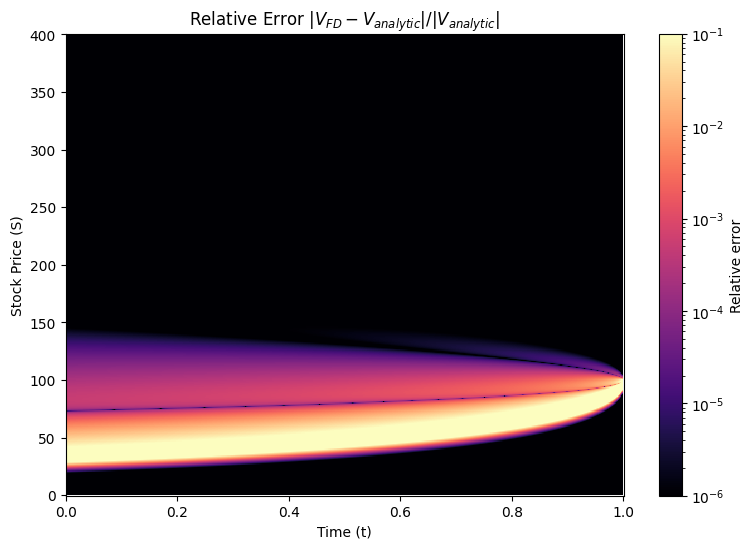

In [146]:
# Relative error heatmap across S–t grid
analytic_surface = np.zeros_like(V)
for j, tau in enumerate(T - t):
    analytic_surface[:, j] = black_scholes_call(S, K, tau, r, sigma)

rel_error = np.abs(V - analytic_surface) / np.maximum(np.abs(analytic_surface), 1e-8)

plt.figure(figsize=(9, 6))
pc = plt.pcolormesh(t, S, rel_error, shading='auto', cmap='magma', norm=LogNorm(vmin=1e-6, vmax=1e-1))
plt.colorbar(pc, label='Relative error')
plt.xlabel('Time (t)')
plt.ylabel('Stock Price (S)')
plt.title(r'Relative Error $|V_{FD} - V_{analytic}| / |V_{analytic}|$')
plt.show()


### Convergence Study
Estimate the empirical order of accuracy by refining \(M\) and \(N\) together and tracking the RMSE at \(t=0\).

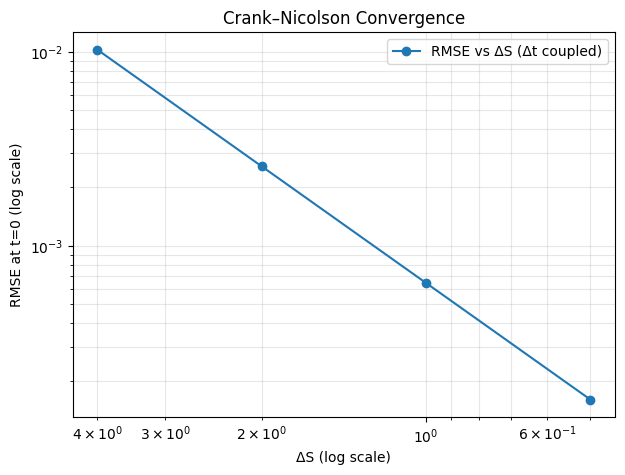

M= 100, N= 250 → ΔS=4.0000, Δt=0.004000, RMSE=1.028606e-02
M= 200, N= 500 → ΔS=2.0000, Δt=0.002000, RMSE=2.571719e-03
M= 400, N=1000 → ΔS=1.0000, Δt=0.001000, RMSE=6.433480e-04
M= 800, N=2000 → ΔS=0.5000, Δt=0.000500, RMSE=1.609135e-04

Estimated convergence order ≈ 2.00


In [147]:
# Convergence analysis for Crank–Nicolson solver
def crank_nicolson_rmse(M, N):
    dS_local = S_max / M
    dt_local = T / N

    S_local = np.linspace(0, S_max, M + 1)
    t_local = np.linspace(0, T, N + 1)

    V_local = np.zeros((M + 1, N + 1))
    V_local[:, -1] = np.maximum(S_local - K, 0)

    i_local = np.arange(1, M)
    a_loc = 0.25 * dt_local * (sigma**2 * i_local**2 - r * i_local)
    b_loc = -0.5 * dt_local * (sigma**2 * i_local**2 + r)
    c_loc = 0.25 * dt_local * (sigma**2 * i_local**2 + r * i_local)

    ab_loc = np.zeros((3, M - 1))
    ab_loc[0, 1:] = -c_loc[:-1]
    ab_loc[1, :] = 1 - b_loc
    ab_loc[2, :-1] = -a_loc[1:]

    theta_local = T - t_local
    V_local[0, :] = 0.0
    V_local[-1, :] = S_max - K * np.exp(-r * theta_local)

    for j in reversed(range(N)):
        rhs_loc = (
            a_loc * V_local[0:M - 1, j + 1]
            + (1 + b_loc) * V_local[1:M, j + 1]
            + c_loc * V_local[2:, j + 1]
        )
        rhs_loc[0] += a_loc[0] * V_local[0, j]
        rhs_loc[-1] += c_loc[-1] * V_local[-1, j]
        V_local[1:M, j] = solve_banded((1, 1), ab_loc, rhs_loc)

    analytic_local = black_scholes_call(S_local, K, T, r, sigma)
    rmse_local = np.sqrt(np.mean((V_local[:, 0] - analytic_local)**2))
    return dS_local, dt_local, rmse_local

# Refinement levels (M doubles, N doubles)
grid_levels = [(100, 250), (200, 500), (400, 1000), (800, 2000)]
results = [crank_nicolson_rmse(M_val, N_val) for M_val, N_val in grid_levels]

cell_sizes = np.array([item[0] for item in results])
rmse_vals = np.array([item[2] for item in results])

order_estimate = np.polyfit(np.log(cell_sizes), np.log(rmse_vals), 1)[0]

plt.figure(figsize=(7, 5))
plt.loglog(cell_sizes, rmse_vals, 'o-', label='RMSE vs ΔS (Δt coupled)')
plt.gca().invert_xaxis()
plt.xlabel('ΔS (log scale)')
plt.ylabel('RMSE at t=0 (log scale)')
plt.title('Crank–Nicolson Convergence')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()

for (M_val, N_val), (_, dt_val, err_val) in zip(grid_levels, results):
    print(f"M={M_val:4d}, N={N_val:4d} → ΔS={S_max / M_val:.4f}, Δt={dt_val:.6f}, RMSE={err_val:.6e}")

print(f"\nEstimated convergence order ≈ {order_estimate:.2f}")


In [140]:
# Inspect worst-case discrepancies for sanity
worst_indices = np.argsort(error)[-5:][::-1]
print("Top 5 absolute errors (t=0 slice):")
for idx in worst_indices:
    print(
        f"S={S[idx]:.2f}: FD={V[idx, 0]:.5f}, Analytical={V_analytic[idx]:.5f}, "
        f"Error={error[idx]:.5e}"
    )


Top 5 absolute errors (t=0 slice):
S=98.00: FD=9.21262, Analytical=9.21511, Error=2.49840e-03
S=97.00: FD=8.62424, Analytical=8.62674, Error=2.49632e-03
S=99.00: FD=9.82073, Analytical=9.82322, Error=2.48974e-03
S=96.00: FD=8.05605, Analytical=8.05853, Error=2.48303e-03
S=100.00: FD=10.44811, Analytical=10.45058, Error=2.47092e-03
